In [1]:
import os
import sys 
import wave
import time
from scipy.signal import spectrogram
from scipy.io.wavfile import read
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import mpld3
# import IPython
from IPython.display import Audio
import librosa
import tensorflow as tf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# mpld3.enable_notebook()

In [3]:
DATA_PATH = "./musicdata/"

In [4]:
sound_file = os.path.join(DATA_PATH, "audiosamples", "short_206377.wav")
#sound_file = "./short_206377.wav"
samples, rate = librosa.load(sound_file)
Audio(url=sound_file)

# Sound as 1D-Signal

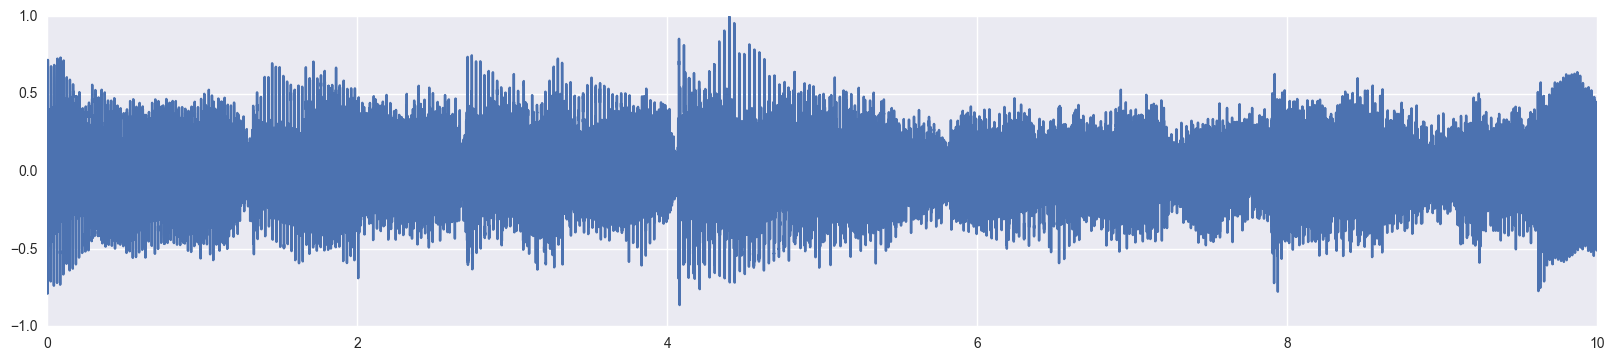

In [5]:
plt.figure(figsize=(20,4))
# 
# Используйте pylab.plot для построения графика, нарисуйте y, sr
#
pylab.plot(np.linspace(0, len(samples) / rate, len(samples)), samples)
pylab.show()

In [6]:
S = librosa.feature.melspectrogram(samples, sr=rate, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

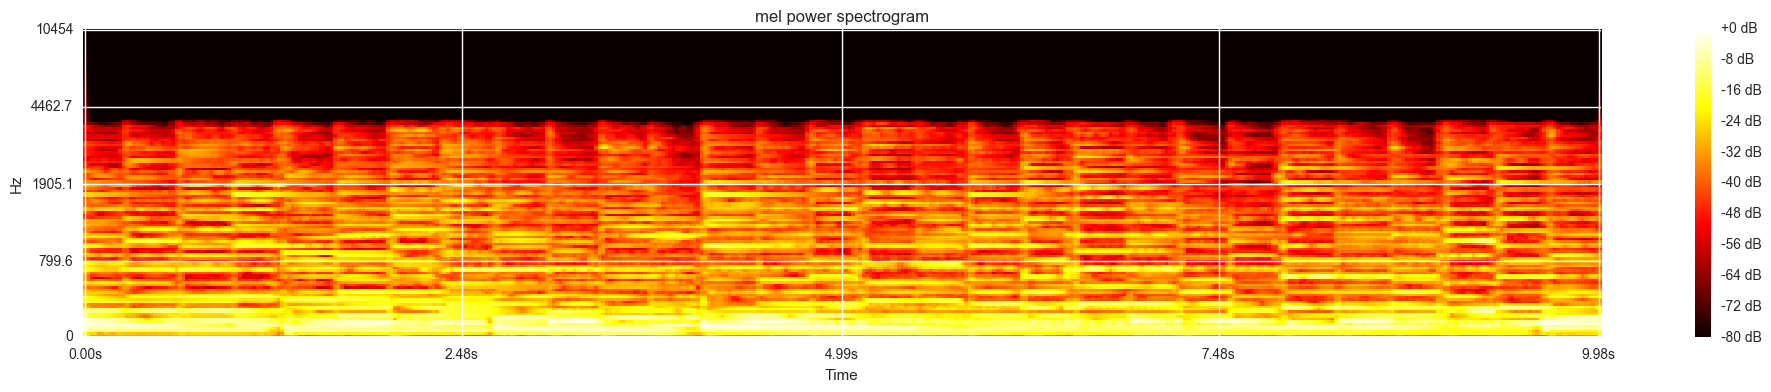

In [7]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=rate, x_axis='time', y_axis='mel', cmap='hot')

plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Загрузим данные:

In [8]:
for i in range(1,8):
    if i == 1:
        X = np.load(os.path.join(DATA_PATH, "spectrograms", "spectrograms{}.pcl".format(i)))
    elif i == 7:
        X_test = np.load(os.path.join(DATA_PATH, "spectrograms", "spectrograms{}.pcl".format(i)))
    else:
        X = np.vstack((X, np.load(os.path.join(DATA_PATH, "spectrograms", "spectrograms{}.pcl".format(i)))))
    print("Unpickled spectrograms{}.pcl".format(i))

Unpickled spectrograms1.pcl
Unpickled spectrograms2.pcl
Unpickled spectrograms3.pcl
Unpickled spectrograms4.pcl
Unpickled spectrograms5.pcl
Unpickled spectrograms6.pcl
Unpickled spectrograms7.pcl


In [9]:
X.astype(np.float32, copy=False)
X_test.astype(np.float32, copy=False)

array([[[-48.17320251, -35.18611908, -20.62840652, ..., -22.23636436,
         -25.78302383, -20.09692574],
        [-31.98403168, -25.7950592 , -16.28125763, ..., -20.75248146,
         -13.27737236,  -7.95897341],
        [-22.91043854, -16.31326675, -13.49856567, ..., -17.34462547,
          -4.97483253,  -1.83852863],
        ..., 
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -80.        ],
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -80.        ],
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -80.        ]],

       [[-12.0765667 , -18.11872482, -29.71771812, ..., -29.41243172,
         -29.71467209, -18.86766243],
        [ -2.22701216,  -6.31130552, -16.35346603, ...,  -8.4231863 ,
          -5.18129444,  -6.65838957],
        [ -4.17789125,  -6.28821754, -13.74742222, ...,  -2.16977239,
          -2.35776615,  -8.85616016],
        ...,

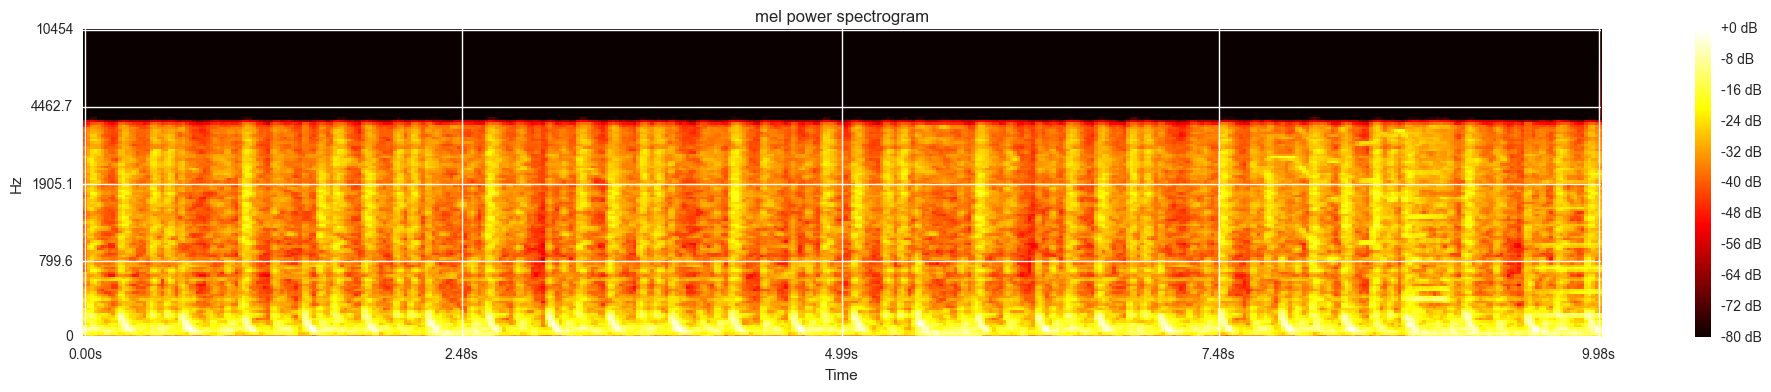

In [10]:
plt.figure(figsize=(20,4))
librosa.display.specshow(X[6], sr=rate, x_axis='time', y_axis='mel', cmap='hot')

plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [11]:
with open(os.path.join(DATA_PATH, "train_genres.txt"), "r") as train:
    genres = list(map(lambda x: x[:-1], train.readlines()))
unique_genres = np.unique(genres)

In [12]:
unique_genres

array(['african', 'alternative', 'amerfolk', 'asiapop', 'balkan', 'bard',
       'blues', 'bollywood', 'celtic', 'children', 'classical', 'conjazz',
       'country', 'dance', 'disco', 'dnb', 'dub', 'dubstep', 'eastern',
       'electronics', 'estrada', 'eurofolk', 'experimental', 'folk',
       'funk', 'hardcore', 'holiday', 'house', 'indie', 'industrial',
       'jazz', 'jewish', 'latinfolk', 'lounge', 'meditation', 'metal',
       'modern', 'musical', 'newage', 'newwave', 'other', 'pop', 'prog',
       'punk', 'rap', 'reggae', 'reggaeton', 'relax', 'rnb', 'rnr', 'rock',
       'rusfolk', 'rusrap', 'rusrock', 'shanson', 'ska', 'soul',
       'soundtrack', 'spiritual', 'spoken', 'sport', 'techno', 'tradjazz',
       'trance', 'ukrrock', 'urban', 'vocal'], 
      dtype='<U12')

In [13]:
y_train = np.array(list(map(lambda x: list(unique_genres).index(x),genres)))

In [14]:
y_train[:10]

array([ 5, 13, 47, 50, 44, 57, 19, 41, 52, 41])

Посмотрим на распределение классов в трейновой выборке:

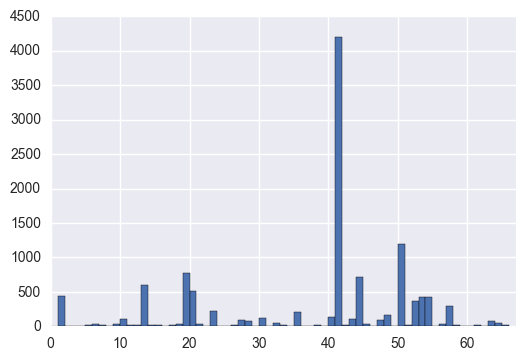

In [15]:
plt.hist(y_train, bins=np.arange(len(unique_genres)))
plt.xlim([0, len(unique_genres)])
plt.show()

In [16]:
len(y_train[y_train == 41])

4204

In [17]:
unique_genres[41]

'pop'

Как видно, датасет сильно несбалансированный: примеров жанра 'pop' в нем гораздо больше, чем всех остальных. Это будет сильно влиять на качество обучения. Чтобы это поправить, нужно как-то сбалансировать классы: можно убрать те, которые встречаются слишком редко и увеличить искусственным образом оставшиеся маленькие классы.

In [18]:
X.shape

(12000, 128, 431)

In [19]:
y_train.shape

(12000,)

In [20]:
def remove_small_classes(X, y):
    unique_y = np.unique(y)
    small_classes = set()
    for i in unique_y:
        if len(y[y == i]) < 180:
            small_classes.add(i)
    print("Found all small classes: {}".format(small_classes))
    if len(small_classes) <= 0:
        return X, y
    len_y = len(y)
    new_X = []
    new_y = []
    for j in np.arange(len_y):
        if y[j] not in small_classes:
            new_X.append(X[j])
            new_y.append(y[j])
    return np.array(new_X), np.array(new_y)

In [21]:
X, y_train = remove_small_classes(X, y_train)

Found all small classes: {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 51, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66}


После удаления маленьких остается 13 классов:

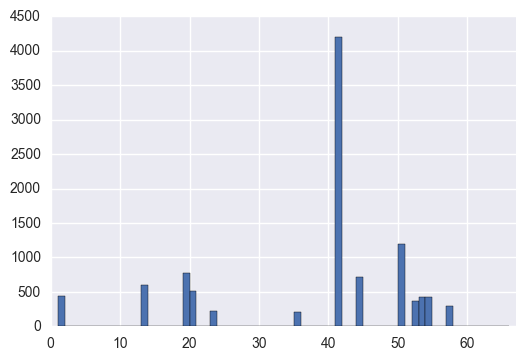

In [22]:
plt.hist(y_train, bins=np.arange(len(unique_genres)))
plt.xlim([0, len(unique_genres)])
plt.show()

Осталось заполнить классы искусственными примерами:

In [ ]:
classes = np.unique(y_train)
X_new = list(X)
y_new = list(y_train)
for class_ in classes:
    if class_ != 41:
        num_samples = len(y_train[y_train == 41]) - len(y_train[y_train == class_])
        indices = np.where(y_train == class_)
        X_new.extend(list(X[np.random.choice(indices[0], num_samples)]))
        y_new.extend([class_] * num_samples)
        print("Added class {}".format(unique_genres[class_]))
print(X_new)
print(y_new)
# X_new = np.array(X_new)
# y_new = np.array(y_new)   

Added class alternative
Added class dance
Added class electronics
Added class estrada
Added class folk
Added class metal
Added class rap
Added class rock
Added class rusrap
Added class rusrock
Added class shanson
Added class soundtrack


In [ ]:
plt.hist(new_y_train, bins=np.arange(len(unique_genres)))
plt.xlim([0, len(unique_genres)])
plt.show()